# Low Rank Matrix Factorization

```{figure} /images/dim_reduction/Netflix_Screenshot.png
---
height: 300px
name: netflix
align: center
---
Low rank matrix factorization can be used for recommender systems like Netflix
```
Netflix gained its big popularity back in the days because it focused on its recommender system strength. They personalized content discovery, ensuring users stayed engaged by always having something new to watch. The task of _recommendation_ is unsupervised, we don't know the ground truth recommendations, as opposed to supervised tasks, where we have a label or target variable.  All we have are past user ratings, from which we try to derive common patterns that allow us to provide recommendations.    

Let's go through an example to get a clearer understanding of the recommender task. Imagine we represent all users and movies in a matrix, where each entry corresponds to a user’s rating for a movie. Then we get a massive, sparse matrix (since most users have only rated a small fraction of available movies). The challenge is to predict the missing ratings so that Netflix can suggest movies that a user is likely to enjoy. For example, the user-movie matrix could look like that:
<style>
.custom-table-container th {
    writing-mode: vertical-lr;
    vertical-align: bottom;
    width: 20%;
}
</style>


<div class="custom-table-container">
    
| User|Star Wars | Interstellar | Blade Runner | Tron | 2001: Space O. | Mars Attacks | Dune | Matrix | Robo Cop | Aliens | Terminator | Solaris | Avatar | 12 Monkeys |
|----|----------|--------------|--------------|------|----------------|--------------|------|--------|----------|--------|------------|---------|--------|-----------| 
| Grace | 🤩 | 🤩 || 🙈 ||| 🤩 || 🤩 | 🤩 | 🤩 || 🤩 ||
| Carol || 🤩 | 🤩 | 🤩 |||| 🤩 |||| 🤩 || 🤩 |
| Alice | 🤩 | 🤩 | 🤩 | 🤩 | 🤩 ||||||| 🤩 | 🙈 ||
| Bob   | 🤩 ||||| 🤩 || 🤩 | 🤩| 🤩 | 🤩|| 🤩||
| Eve   | 🤩 |||| 🙈 | 🤩 || 🤩 | 🤩 |||| 🤩 ||
| Chuck | 🤩 |🤩|| 🤩| 🤩 | 🤩 | 🤩 | 🤩 || 🤩 | 🤩 || 🙈 |🤩 |
    
</div>

We have six users and 14 movies, that are rated either as _I like it_ (🤩) or _not for me_ (🙈). If no emoji is indicated, then the corresponding user has not seen the movie yet. This example matrix of user-movie preferences exhibits two patterns of preferences. The first pattern consists of the movies _Star Wars, Interstellar, Blade Runner, Tron, 2001: Space Odyssey, Matrix, Solaris,_ and _12 Monkeys_. This set of movies is popular in the user group of Carol, Alice and Chuck: every movie of the set is liked at least by two of the three users. Hence, we might consider to recommend each person of that group a movie from this set that the person has not watched yet. For example, we could recommend to Carol to watch _2001: Space Odyssey_.
Likewise, we identify a second pattern of movies that is popular among the group of Grace, Bob, Eve and Chuck. This pattern encompasses the movies _Star Wars, Mars Attacks, Matrix, Robo Cop, Aliens, Terminator_, and _Avatar_.       

Let's visualize the model that we are looking for as a matrix. Below you see the abstract representation of the groups of users and movies as a matrix. The first group of users (Carol, Alice and Chuck) and their corresponding set of (largely) liked movies is visualized in blue, and the second set of users (Grace, Bob, Eve and Chuck) and their set of movies are visualized in red.

In [382]:
def plot_matrix(matrix, ax, vmin=0, vmax=3,  grid=True): 
    ax.imshow(matrix,cmap=cmap, vmin=vmin, vmax=vmax)
    # Add grid lines for x-axis
    #plt.xticks(np.arange(-0.5, matrix.shape[1], 1), [])
    ax.set_xticks(np.arange(-0.5, matrix.shape[1], 1), [])
    ax.set_yticks(np.arange(-0.5, matrix.shape[0], 1), [])
    if grid:
        ax.grid(axis='x', color='lightgray', linewidth=3)

        # Add grid lines for y-axis
        #plt.yticks(np.arange(-0.5, matrix.shape[0], 1), [])
        ax.grid(axis='y', color='lightgray', linewidth=3)
    # Remove frame axis lines
    #ax = plt.gca()
    ax.tick_params(bottom=False, top=False, left=False, right=False)
    # Remove frame axis lines
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

::::{grid}
:gutter: 1
:class-container: sd-d-flex-row, sd-align-major-center

:::{grid-item}
:child-align: center
:columns: auto
```{tikz}
\begin{tikzpicture}[baseline=-0.5ex,
    style1/.style 2 args={
  matrix of math nodes,
  every node/.append style={minimum width=#2,minimum height=#1,inner sep=0,align=center},
  nodes in empty cells,
  left delimiter=(,
  right delimiter=),ampersand replacement=\&}
  ]
   \matrix [style1={5mm}{5mm}] (D) {
   |[fill=magenta, opacity=0.5]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\& |[fill=magenta, opacity=0.5]| \&|[fill=orange, opacity=0.05]|\& |[fill=magenta, opacity=0.5]|\& |[fill=magenta, opacity=0.5]|\& |[fill=magenta, opacity=0.5]|\& |[fill=magenta, opacity=0.5]|\& |[fill=orange, opacity=0.05]|\&|[fill=magenta, opacity=0.5]| \&|[fill=orange, opacity=0.05]|\\
 |[fill=blue, opacity=0.5]|\& |[fill=blue, opacity=0.5]| \& |[fill=blue, opacity=0.5]| \& |[fill=blue, opacity=0.5]| \& |[fill=blue, opacity=0.5]| \& |[fill=orange, opacity=0.05]|\& |[fill=orange, opacity=0.05]|\& |[fill=blue, opacity=0.5]| \& |[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=blue, opacity=0.5]|\&|[fill=orange, opacity=0.05]|\&|[fill=blue, opacity=0.5]|\\
 |[fill=blue, opacity=0.5]|\& |[fill=blue, opacity=0.5]| \& |[fill=blue, opacity=0.5]| \& |[fill=blue, opacity=0.5]| \& |[fill=blue, opacity=0.5]| \& |[fill=orange, opacity=0.05]|\& |[fill=orange, opacity=0.05]|\& |[fill=blue, opacity=0.5]| \&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=blue, opacity=0.5]|\&|[fill=orange, opacity=0.05]|\&|[fill=blue, opacity=0.5]|\\
 |[fill=magenta, opacity=0.5]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\& |[fill=magenta, opacity=0.5]| \&|[fill=orange, opacity=0.05]|\& |[fill=magenta, opacity=0.5]|\& |[fill=magenta, opacity=0.5]|\& |[fill=magenta, opacity=0.5]|\& |[fill=magenta, opacity=0.5]|\& |[fill=orange, opacity=0.05]|\&|[fill=magenta, opacity=0.5]| \&|[fill=orange, opacity=0.05]|\\
 |[fill=magenta, opacity=0.5]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\& |[fill=magenta, opacity=0.5]| \&|[fill=orange, opacity=0.05]|\& |[fill=magenta, opacity=0.5]|\& |[fill=magenta, opacity=0.5]|\& |[fill=magenta, opacity=0.5]|\& |[fill=magenta, opacity=0.5]|\& |[fill=orange, opacity=0.05]|\&|[fill=magenta, opacity=0.5]| \&|[fill=orange, opacity=0.05]|\\
 |[fill=magenta, opacity=0.5]|\&|[fill=blue, opacity=0.5]|\&|[fill=blue, opacity=0.5]|\&|[fill=blue, opacity=0.5]|\&|[fill=blue, opacity=0.5]|\& |[fill=magenta, opacity=0.5]| \&|[fill=orange, opacity=0.05]|\& |[fill=magenta, opacity=0.5]|\& |[fill=magenta, opacity=0.5]|\& |[fill=magenta, opacity=0.5]|\& |[fill=magenta, opacity=0.5]|\& |[fill=blue, opacity=0.5]|\&|[fill=magenta, opacity=0.5]| \&|[fill=blue, opacity=0.5]|\\
};

\node[fit=(D-6-1),inner sep=0pt, fill=blue, opacity=0.5] {};
\node[fit=(D-6-8),inner sep=0pt, fill=blue, opacity=0.5] {};
\end{tikzpicture}
```
:::


::::


The matrix above reflects the positive movie indications (🤩) by the nonzero cells, that are the ones that are colored. The last row reflects Chuck, who adheres to both movie patterns, that overlap in the movies _Star Wars_ and _Matrix_. Hence, we see two cells in the last row with overlapping colors. The user-movie matrix can be decomposed into the sum of two matrices, where each matrix reflects one user-movie group.

::::{grid}
:gutter: 0
:class-container: sd-d-flex-row, sd-align-major-center

:::{grid-item}
:child-align: center
:columns: auto
```{tikz}
\begin{tikzpicture}[baseline=-0.5ex,
    style1/.style 2 args={
  matrix of math nodes,
  every node/.append style={minimum width=#2,minimum height=#1,inner sep=0,align=center},
  nodes in empty cells,
  left delimiter=(,
  right delimiter=),ampersand replacement=\&}
  ]
   \matrix [style1={5mm}{5mm}] (D) {
   |[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\& |[fill=orange, opacity=0.05]| \&|[fill=orange, opacity=0.05]|\& |[fill=orange, opacity=0.05]|\& |[fill=orange, opacity=0.05]|\& |[fill=orange, opacity=0.05]|\& |[fill=orange, opacity=0.05]|\& |[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]| \&|[fill=orange, opacity=0.05]|\\
 |[fill=blue, opacity=0.5]|\& |[fill=blue, opacity=0.5]| \& |[fill=blue, opacity=0.5]| \& |[fill=blue, opacity=0.5]| \& |[fill=blue, opacity=0.5]| \& |[fill=orange, opacity=0.05]|\& |[fill=orange, opacity=0.05]|\& |[fill=blue, opacity=0.5]| \& |[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=blue, opacity=0.5]|\&|[fill=orange, opacity=0.05]|\&|[fill=blue, opacity=0.5]|\\
 |[fill=blue, opacity=0.5]|\& |[fill=blue, opacity=0.5]| \& |[fill=blue, opacity=0.5]| \& |[fill=blue, opacity=0.5]| \& |[fill=blue, opacity=0.5]| \& |[fill=orange, opacity=0.05]|\& |[fill=orange, opacity=0.05]|\& |[fill=blue, opacity=0.5]| \&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=blue, opacity=0.5]|\&|[fill=orange, opacity=0.05]|\&|[fill=blue, opacity=0.5]|\\
 |[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\& |[fill=orange, opacity=0.05]| \&|[fill=orange, opacity=0.05]|\& |[fill=orange, opacity=0.05]|\& |[fill=orange, opacity=0.05]|\& |[fill=orange, opacity=0.05]|\& |[fill=orange, opacity=0.05]|\& |[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]| \&|[fill=orange, opacity=0.05]|\\
 |[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\& |[fill=orange, opacity=0.05]| \&|[fill=orange, opacity=0.05]|\& |[fill=orange, opacity=0.05]|\& |[fill=orange, opacity=0.05]|\& |[fill=orange, opacity=0.05]|\& |[fill=orange, opacity=0.05]|\& |[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]| \&|[fill=orange, opacity=0.05]|\\
 |[fill=blue, opacity=0.5]|\&|[fill=blue, opacity=0.5]|\&|[fill=blue, opacity=0.5]|\&|[fill=blue, opacity=0.5]|\&|[fill=blue, opacity=0.5]|\& |[fill=orange, opacity=0.05]| \&|[fill=orange, opacity=0.05]|\& |[fill=blue, opacity=0.5]|\& |[fill=orange, opacity=0.05]|\& |[fill=orange, opacity=0.05]|\& |[fill=orange, opacity=0.05]|\& |[fill=blue, opacity=0.5]|\&|[fill=orange, opacity=0.05]| \&|[fill=blue, opacity=0.5]|\\
};
\end{tikzpicture}
```
:::

:::{grid-item}
:child-align: center
:columns: auto
$+$
:::

:::{grid-item}
:child-align: center
:columns: auto
```{tikz}
\begin{tikzpicture}[baseline=-0.5ex,
    style1/.style 2 args={
  matrix of math nodes,
  every node/.append style={minimum width=#2,minimum height=#1,inner sep=0,align=center},
  nodes in empty cells,
  left delimiter=(,
  right delimiter=),ampersand replacement=\&}
  ]
   \matrix [style1={5mm}{5mm}] (D) {
   |[fill=magenta, opacity=0.5]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\& |[fill=magenta, opacity=0.5]| \&|[fill=orange, opacity=0.05]|\& |[fill=magenta, opacity=0.5]|\& |[fill=magenta, opacity=0.5]|\& |[fill=magenta, opacity=0.5]|\& |[fill=magenta, opacity=0.5]|\& |[fill=orange, opacity=0.05]|\&|[fill=magenta, opacity=0.5]| \&|[fill=orange, opacity=0.05]|\\
 |[fill=orange, opacity=0.05]|\& |[fill=orange, opacity=0.05]| \& |[fill=orange, opacity=0.05]| \& |[fill=orange, opacity=0.05]| \& |[fill=orange, opacity=0.05]| \& |[fill=orange, opacity=0.05]|\& |[fill=orange, opacity=0.05]|\& |[fill=orange, opacity=0.05]| \& |[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\\
 |[fill=orange, opacity=0.05]|\& |[fill=orange, opacity=0.05]| \& |[fill=orange, opacity=0.05]| \& |[fill=orange, opacity=0.05]| \& |[fill=orange, opacity=0.05]| \& |[fill=orange, opacity=0.05]|\& |[fill=orange, opacity=0.05]|\& |[fill=orange, opacity=0.05]| \&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\\
 |[fill=magenta, opacity=0.5]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\& |[fill=magenta, opacity=0.5]| \&|[fill=orange, opacity=0.05]|\& |[fill=magenta, opacity=0.5]|\& |[fill=magenta, opacity=0.5]|\& |[fill=magenta, opacity=0.5]|\& |[fill=magenta, opacity=0.5]|\& |[fill=orange, opacity=0.05]|\&|[fill=magenta, opacity=0.5]| \&|[fill=orange, opacity=0.05]|\\
 |[fill=magenta, opacity=0.5]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\& |[fill=magenta, opacity=0.5]| \&|[fill=orange, opacity=0.05]|\& |[fill=magenta, opacity=0.5]|\& |[fill=magenta, opacity=0.5]|\& |[fill=magenta, opacity=0.5]|\& |[fill=magenta, opacity=0.5]|\& |[fill=orange, opacity=0.05]|\&|[fill=magenta, opacity=0.5]| \&|[fill=orange, opacity=0.05]|\\
 |[fill=magenta, opacity=0.5]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\& |[fill=magenta, opacity=0.5]| \&|[fill=orange, opacity=0.05]|\& |[fill=magenta, opacity=0.5]|\& |[fill=magenta, opacity=0.5]|\& |[fill=magenta, opacity=0.5]|\& |[fill=magenta, opacity=0.5]|\& |[fill=orange, opacity=0.05]|\&|[fill=magenta, opacity=0.5]| \&|[fill=orange, opacity=0.05]|\\
};

\end{tikzpicture}
```
:::

::::


::::{grid}
:gutter: 0
:class-container: sd-d-flex-row, sd-align-major-center


:::{grid-item}
:child-align: center
:columns: auto
```{tikz}
\begin{tikzpicture}[baseline=-0.5ex,
    style1/.style 2 args={
  matrix of math nodes,
  every node/.append style={minimum width=#2,minimum height=#1,inner sep=0,align=center},
  nodes in empty cells,
  left delimiter=(,
  right delimiter=),ampersand replacement=\&}
  ]
   \matrix [style1={5mm}{5mm}] (D) {
   |[fill=orange, opacity=0.05]|\\
 |[fill=blue, opacity=0.5]|\\
 |[fill=blue, opacity=0.5]|\\
 |[fill=orange, opacity=0.05]|\\
 |[fill=orange, opacity=0.05]|\\
 |[fill=blue, opacity=0.5]|\\
};
\end{tikzpicture}
```
:::
:::{grid-item}
:child-align: center
:columns: auto
```{tikz}
\begin{tikzpicture}[baseline=-0.5ex,
    style1/.style 2 args={
  matrix of math nodes,
  every node/.append style={minimum width=#2,minimum height=#1,inner sep=0,align=center},
  nodes in empty cells,
  left delimiter=(,
  right delimiter=),ampersand replacement=\&}
  ]
   \matrix [style1={5mm}{5mm}] (D) {
 |[fill=blue, opacity=0.5]|\& |[fill=blue, opacity=0.5]| \& |[fill=blue, opacity=0.5]| \& |[fill=blue, opacity=0.5]| \& |[fill=blue, opacity=0.5]| \& |[fill=orange, opacity=0.05]|\& |[fill=orange, opacity=0.05]|\& |[fill=blue, opacity=0.5]| \& |[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=blue, opacity=0.5]|\&|[fill=orange, opacity=0.05]|\&|[fill=blue, opacity=0.5]|\\
};
\end{tikzpicture}
```
:::

:::{grid-item}
:child-align: center
:columns: auto
$+$
:::

:::{grid-item}
:child-align: center
:columns: auto
```{tikz}
\begin{tikzpicture}[baseline=-0.5ex,
    style1/.style 2 args={
  matrix of math nodes,
  every node/.append style={minimum width=#2,minimum height=#1,inner sep=0,align=center},
  nodes in empty cells,
  left delimiter=(,
  right delimiter=),ampersand replacement=\&}
  ]
   \matrix [style1={5mm}{5mm}] (D) {
   |[fill=magenta, opacity=0.5]|\\
 |[fill=orange, opacity=0.05]|\\
 |[fill=orange, opacity=0.05]|\\
 |[fill=magenta, opacity=0.5]|\\
 |[fill=magenta, opacity=0.5]|\\
 |[fill=magenta, opacity=0.5]|\\
};

\end{tikzpicture}
```
:::

:::{grid-item}
:child-align: center
:columns: auto
```{tikz}
\begin{tikzpicture}[baseline=-0.5ex,
    style1/.style 2 args={
  matrix of math nodes,
  every node/.append style={minimum width=#2,minimum height=#1,inner sep=0,align=center},
  nodes in empty cells,
  left delimiter=(,
  right delimiter=),ampersand replacement=\&}
  ]
   \matrix [style1={5mm}{5mm}] (D) {
   |[fill=magenta, opacity=0.5]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\& |[fill=magenta, opacity=0.5]| \&|[fill=orange, opacity=0.05]|\& |[fill=magenta, opacity=0.5]|\& |[fill=magenta, opacity=0.5]|\& |[fill=magenta, opacity=0.5]|\& |[fill=magenta, opacity=0.5]|\& |[fill=orange, opacity=0.05]|\&|[fill=magenta, opacity=0.5]| \&|[fill=orange, opacity=0.05]|\\
};
\end{tikzpicture}
```
:::

::::


Furthermore, each of the single user-group matrices can be represented by an outer product of a user- and a user-vector. And the sum of outer product matrices reflects a low-dimensional matrix product. In this casse, we have a product of two dimensionality two -- one for each user-movie matrix. 

::::{grid}
:gutter: 0
:class-container: sd-d-flex-row, sd-align-major-center


:::{grid-item}
:child-align: center
:columns: auto
```{tikz}
\begin{tikzpicture}[baseline=-0.5ex,
    style1/.style 2 args={
  matrix of math nodes,
  every node/.append style={minimum width=#2,minimum height=#1,inner sep=0,align=center},
  nodes in empty cells,
  left delimiter=(,
  right delimiter=),ampersand replacement=\&}
  ]
   \matrix [style1={5mm}{5mm}] (D) {
   |[fill=orange, opacity=0.05]|\& |[fill=magenta, opacity=0.5]|\\
 |[fill=blue, opacity=0.5]|\& |[fill=orange, opacity=0.05]|\\
 |[fill=blue, opacity=0.5]|\& |[fill=orange, opacity=0.05]|\\
 |[fill=orange, opacity=0.05]|\& |[fill=magenta, opacity=0.5]|\\
 |[fill=orange, opacity=0.05]|\& |[fill=magenta, opacity=0.5]|\\
 |[fill=blue, opacity=0.5]|\& |[fill=magenta, opacity=0.5]|\\
};
\end{tikzpicture}
```
:::
:::{grid-item}
:child-align: center
:columns: auto
```{tikz}
\begin{tikzpicture}[baseline=-0.5ex,
    style1/.style 2 args={
  matrix of math nodes,
  every node/.append style={minimum width=#2,minimum height=#1,inner sep=0,align=center},
  nodes in empty cells,
  left delimiter=(,
  right delimiter=),ampersand replacement=\&}
  ]
   \matrix [style1={5mm}{5mm}] (D) {
 |[fill=blue, opacity=0.5]|\& |[fill=blue, opacity=0.5]| \& |[fill=blue, opacity=0.5]| \& |[fill=blue, opacity=0.5]| \& |[fill=blue, opacity=0.5]| \& |[fill=orange, opacity=0.05]|\& |[fill=orange, opacity=0.05]|\& |[fill=blue, opacity=0.5]| \& |[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=blue, opacity=0.5]|\&|[fill=orange, opacity=0.05]|\&|[fill=blue, opacity=0.5]|\\
 |[fill=magenta, opacity=0.5]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\&|[fill=orange, opacity=0.05]|\& |[fill=magenta, opacity=0.5]| \&|[fill=orange, opacity=0.05]|\& |[fill=magenta, opacity=0.5]|\& |[fill=magenta, opacity=0.5]|\& |[fill=magenta, opacity=0.5]|\& |[fill=magenta, opacity=0.5]|\& |[fill=orange, opacity=0.05]|\&|[fill=magenta, opacity=0.5]| \&|[fill=orange, opacity=0.05]|\\
};
\end{tikzpicture}
```
:::

::::


The low-dimensional matrix product describing our user-movie preferences is now represented by two user-vectors (the columns of the left matrix) and two movie-vectors (the rows of the right matrix). Each pair of user- and movie-vectors indicates a group, exhibiting the same movie preferences. Note, that the original $6\times 14$ matrix is now compressed into a $6\times 2$-matrix and a $2\times 14$ matrix. While the original matrix contains $6\cdot 14 = 84$ elements, the low-dimensional product needs only $2\cdot 6 + 2\cdot 14 = 40$ elememts to be stored. That is roughly the idea of recommender systems: using reoccurences in the behaviour or similarities among users and movies to compress the data, and to use the compressed data representation to make recommendations.

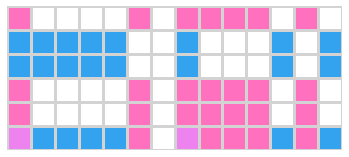

In [381]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

jupyter_blue = (0+0.2, 113/255+0.2, 188/255+0.2)
jupyter_orange = (min(242/255+0.2,1), 115/255+0.2, 33/255+0.2)
jupyter_magenta = (min(232/255+0.2,1), 62/255+0.2, 140/255+0.2)


# Define the colors for the colormap
colors = ['white', jupyter_blue, jupyter_magenta, "violet"]

# Define the values corresponding to each color
values = [0, 1, 2, 3]

# Create the custom colormap
cmap = ListedColormap(colors)
P_1 = np.array([0,1,1,0,0,1])
P1_ = np.array([1,1,1,1,1,0,0,1,0,0,0,1,0,1])
P_2 = np.array([1,0,0,1,1,1])
P2_ = np.array([1,0,0,0,0,1,0,1,1,1,1,0,1,0])
P1 = np.outer(P_1,P1_)
P2 = 2*np.outer(P_2,P2_)
ax = plt.gca()
plot_matrix(P1+P2,ax)
plt.show()

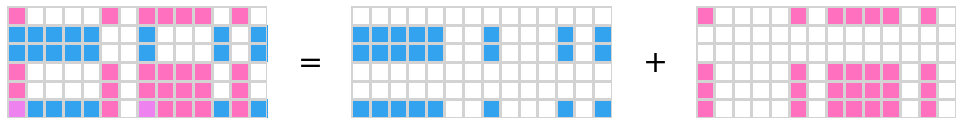

In [380]:
fig,axs = plt.subplots(1,5, figsize = (17,8), gridspec_kw = {"width_ratios": [P1.shape[1], 1, P1.shape[1],1, P1.shape[1]]})
plot_matrix(P1+P2, axs[0])
# =
plot_matrix(np.zeros((P1.shape[0],1)), axs[1], grid=False)
axs[1].text(-0.6,3, '=', fontsize=30)

plot_matrix(P1, axs[2])
# +
plot_matrix(np.zeros((P1.shape[0],1)), axs[3], grid=False)
axs[3].text(-0.6,3, '+', fontsize=30)

plot_matrix(P2, axs[4])

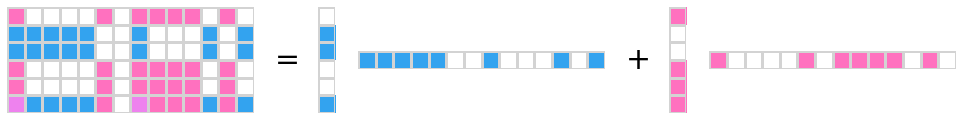

In [378]:
fig,axs = plt.subplots(1,7, figsize = (17,8), gridspec_kw = {"width_ratios": [P1.shape[1], 1, 1, P1.shape[1],1, 1,P1.shape[1]]})
plot_matrix(P1+P2, axs[0])
plot_matrix(np.zeros((P1.shape[0],1)), axs[1], grid=False)
axs[1].text(-0.6,3, '=', fontsize=30)

plot_matrix(np.reshape(P_1, (P_1.shape[0], 1)), axs[2])
plot_matrix(np.reshape(P1_, (1, P1_.shape[0])), axs[3])
plot_matrix(np.zeros((P1.shape[0],1)), axs[4], grid=False)
axs[4].text(-0.6,3, '+', fontsize=30)
plot_matrix(2*np.reshape(P_2, (P_2.shape[0], 1)), axs[5])
plot_matrix(2*np.reshape(P2_, (1, P2_.shape[0])), axs[6])

## Formal Problem Definition
We formalize the idea to obtain recommendations by compressing the data as the task to minimize the squared Frobenius-norm error of a low-rank matrix product and the data matrix.
`````{admonition} Task (Rank-r Matrix Factorization)
:class: tip
**Given** a data matrix $D\in\mathbb{R}^{n\times d}$ and a rank $r<\min\{n,d\}$.        
    
**Find** matrices $X\in \mathbb{R}^{d\times r}$ and $Y\in\mathbb{R}^{n\times r}$ whose product approximates the data matrix:
\begin{align}
    \min_{X,Y}&\lVert D- YX^\top\rVert^2 & \text{s.t. } X\in \mathbb{R}^{d\times r}, Y\in\mathbb{R}^{n\times r}
\end{align}
**Return** the low-dimensional approximation of the data $(X,Y)$.  
`````
Note that the Rank-r matrix factorization task is not directly suitable to return recommendations. It only describes the task to compress a given data matrix into a low-dimensional product. To provide recommendations, we need to fill in missing values. We will discuss later how we can do this with a low dimensional matrix factorization.    
First, we analyze properties of the objective, as it turns out, the low-dimensional matrix factorization task is nonconvex. 
````{prf:theorem}
The rank-$r$ matrix factorization problem, defined for a matrix $D\in\mathbb{R}^{n\times d}\neq\mathbf{0}$ and a rank $1\leq r<\min\{n,d\}$ as           
\begin{align*}
    \min_{X,Y}& RSS(X,Y)=\lVert D- YX^\top\rVert^2 & \text{s.t. } X\in \mathbb{R}^{d\times r}, Y\in\mathbb{R}^{n\times r}
\end{align*}
is a **nonconvex optimization problem**.
````
The proof follows from the fact that the set of global minimizers is not a convex set.
````{toggle}
```{prf:proof}
We show that the $RSS(X,Y)$ is not a convex function. Therefore we assume first that the $RSS(X,Y)$ is a convex function and show then that this assumption leads to a contradiction. Assuming that the $RSS(X,Y)$ is a convex function means that the following inequality has to hold for all matrices $X_1,X_2\in\mathbb{R}^{d\times r}$ and $Y_1,Y_2\in\mathbb{R}^{n\times r}$ and $\alpha\in[0,1]$:
\begin{align}
        RSS(\alpha X_1+ (1-\alpha)X_2,\alpha Y_1 + (1-\alpha)Y_2) \leq \alpha RSS(X_1,Y_1) + (1-\alpha)RSS(X_2,Y_2).
\end{align}
For any global minimizer $(X,Y)$ of the rank-$r$ MF problem, $(\gamma X, \frac{1}{\gamma} Y)$ is also a global minimizer for $\gamma\neq 0$.
However, for $\alpha=1/2$ the convex combination attains a function value of
\begin{align*}
    RSS(\alpha X + (1-\alpha) (\gamma X), \alpha Y+(1-\alpha)(\tfrac1\gamma Y)) &=RSS\left(\tfrac12 X + \tfrac12 (\gamma X), \tfrac12 Y+\tfrac12(\tfrac1\gamma Y)\right)\\
    &= RSS\left(\tfrac12(1+\gamma) X, \tfrac12(1+ \tfrac1\gamma) Y\right)\\
    &=\lVert D-\tfrac14(1+\gamma)(1+\tfrac1\gamma)YX^\top\rVert^2.
\end{align*}
We observe that the approximation error in the last equation goes to infinity if $\gamma\rightarrow \infty$. Hence, there exists multiple $\gamma>0$ for which the $RSS$ of the convex combination of two global minimizers is larger than zero. This contradicts the assumption that the $RSS(X,Y)$ is convex.
```
````
We observe from the proof that there are infinitely many global minimizers for the low-dimensional matrix factorization task. Let's explore this set of global minimizers by means of an example in one dimension.
````{prf:example} One-dimensional matrix factorization   
The most _easy_ case of a low-dimensional matrix factorization is the factorization of a single number. Let's take for example the factorization of the number one into a product of two factors $x_1$ and $x_2$, having the objective function  $f(x_1,x_2) = (1-x_1x_2)^2$. We plot the graph of the objective function together with three solutions: $(x_1,x_2)=(2,0.5)$, $(1,1)$, and $(0.5,2)$.
```{tikz}
\begin{tikzpicture}
\begin{axis}[width=1.4\textwidth,xlabel=$x_1$,ylabel=$x_2$,zlabel=$y$,zmin=0,axis lines = center,zmax=4.1,xmin=0,xmax=2.5,ymin=0,ymax=2.5,view={45}{45},
x label style={at={(xticklabel* cs:1,-0.1)},anchor=north},
y label style={at={(yticklabel* cs:1.2,0)},anchor=north},
z label style={at={(zticklabel* cs:1.1,0.1)},anchor=north},
yticklabels={,,},xticklabels={,,},zticklabels={,,}]
\addplot3[
    mesh, samples=15, domain=0:2.5,
]
{(1-x*y)^2};
\node[label={45:{$(1,1)$}},circle,fill,inner sep=2pt] at (axis cs:1,1) {};
\node[label={45:{$(0.5,2)$}},circle,fill,inner sep=2pt] at (axis cs:0.5,2) {};
\node[label={45:{$(2,0.5)$}},circle,fill,inner sep=2pt] at (axis cs:2,0.5) {};
\end{axis}
\end{tikzpicture}
```
We can observe the nonconvexity of this function by connecting the solution of $(0.5,2)$ with $(2,0.5)$ with a straight line. If the function would be convex, then the graph ofthe function would be under or on the line. Under the line is not possible in this case, since the solution points we picked are global minimizers. Hence, the graph should be flat ($y$-value equal to zero) on the line between the two solutions, but we see that the loss increases to the right. However, we also see that the loss function doesn't look as if there is a multitude of valleys, that are local minima. That gives us hope, that the low-rank matrix factorization task is not that difficult to solve.   
````
## Optimization

In most cases, nonconvexity of an objective implies that we probably have to live with the fact that we can not determine the global minimum, and that we can only hope to get good local minima by numerical optimization methods such as gradient descent. The rank-$r$ matrix factorization problem is here an exemption to the rule, since we can derive one global minimum by SVD. 

````{prf:theorem} Truncated SVD
Let $D=U\Sigma V^\top\in\mathbb{R}^{n\times d}$ be the singular decomposition of $D$. Then the global minimizers $X$ and $Y$  of the rank-$r$ MF problem 
\begin{align}
\min_{X,Y}\lVert D-YX^\top\rVert^2 \text{s.t. } X\in \mathbb{R}^{d\times r}, Y\in\mathbb{R}^{n\times r}.
\end{align}
satisfy 
\begin{align} 
YX^\top = U_{\cdot \mathcal{R}}\Sigma_{\mathcal{R}\mathcal{R}}V_{\cdot \mathcal{R}}^\top, \text{ where }\mathcal{R}=\{1,\ldots, r\}.
\end{align}
````
````{prf:proof}
The proof follows from
the orthogonal invariance of the Frobenius norm, yielding:
\begin{align*}
    \min_{X,Y}&\lVert D-YX^\top\rVert^2 = \lVert \Sigma - U^\top YX^\top V\rVert^2 
\end{align*}
````


## Implementation of a Recommender System
Ok, so the truncated SVD solves the task to determine a low-rank approximation of my data.
How can we apply the low-rank approximation to provide recommendations? 
Fill missing values with the mean value and compute the truncated SVD.

| Id| $A$ | $B$ | $C$ | $D$|
|---|-----|-----|-----|----|
| 1 | ★★★★★ | ? | ★★☆☆☆ | ★☆☆☆☆ |
| 2 | ? | ★☆☆☆☆ | ★★★★★ | ? |
| 3 | ★★★★★ | ★☆☆☆☆ | ★★★★★ | ★★☆☆☆|
| 4 | ★★★★★ | ? | ★★★★★ | ★★★☆☆|
| 5 | ★★★★★ | ★★★★★ | ? | ? |
| 6 | ? | ★★★★☆| ★★★★★ | ★★★☆☆ |

Can we fill the question marks with the rating which would be given by the user if they had seen the movie?

Quick hack: we replace the unobserved entries with the mean rating $\mu=\frac{1+2+3+4+5}{5}=3$.

In [396]:
D = np.array([[5,3,1,1],[3,1,5,3],[2,1,5,3],[4,3,4,2],[5,5,3,1],[3,1,5,3]])
D

array([[5, 3, 1, 1],
       [3, 1, 5, 3],
       [2, 1, 5, 3],
       [4, 3, 4, 2],
       [5, 5, 3, 1],
       [3, 1, 5, 3]])

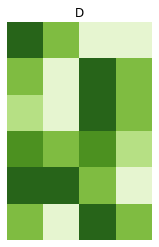

In [397]:
plt.imshow(D,vmin = -5, vmax = 5)
plt.title("D")
plt.set_cmap('PiYG')
plt.axis('off')
plt.show()

In [398]:
U, s, Vᵀ = np.linalg.svd(D,full_matrices=True)

We get a rank-2 approximation of $D$ by the truncated SVD $D\approx U_{\cdot \{1,2\}}\Sigma_{\{1,2\}\{1,2\}}V_{\cdot \{1,2\}}^\top$. This tri-factorization can be expressed as a factorization into two matrices by setting $Y=U_{\cdot \{1,2\}}\Sigma_{\{1,2\}\{1,2\}}^{1/2}$ and $X=V_{\cdot \{1,2\}}\Sigma_{\{1,2\}\{1,2\}}^{1/2}$. 
```{note}
The matrix $A^{1/2}$ is defined as the matrix that satisfies the equation $A^{1/2}A^{1/2}=A$. Not for all matrices $A$ exists such a matrix $A^{1/2}$. However, for nonnegative, diagonal matrices $\Sigma$, the matrix $\Sigma^{1/2}=\diag(\sqrt{\sigma_1},\ldots, \sqrt{\sigma_r})$ exists.
```

In [401]:
np.set_printoptions(precision=2,suppress=True)
Y = U[:,0:2]*np.sqrt(s[0:2])
Y

array([[-1.3 ,  1.26],
       [-1.61, -0.85],
       [-1.46, -1.04],
       [-1.71,  0.21],
       [-1.81,  1.27],
       [-1.61, -0.85]])

In [400]:
X = Vᵀ.T[:,0:2]*np.sqrt(s[0:2])
X

array([[-2.3 ,  1.08],
       [-1.49,  1.38],
       [-2.43, -1.36],
       [-1.35, -0.92]])

The low rank approximation can be used to give recommendations.

In [404]:
Y@X.T

array([[4.34, 3.68, 1.43, 0.59],
       [2.78, 1.23, 5.08, 2.97],
       [2.23, 0.75, 4.97, 2.93],
       [4.16, 2.84, 3.88, 2.13],
       [5.53, 4.46, 2.68, 1.28],
       [2.78, 1.23, 5.08, 2.97]])

\begin{align}
  \begin{pmatrix}
    5 & \mu & 1 & 1 \\
    \mu & 1 & 5 & \mu  \\\
    2 & 1 & 5 & 3 \\
    4 & \mu & 4 & 2\\
    5 & 5 & \mu & 1 \\
    \mu & 1 & 5 & 3 \\
  \end{pmatrix}
  &\approx
  \begin{pmatrix}
    4.3 & 3.7 & 1.4 & 0.6\\
    2.8 & 1.2 & 5.1 & 3.0\\
    2.2 & 0.7 & 5.0 & 2.9\\
    4.2 & 2.8 & 3.9 & 2.1\\
    5.5 & 4.5 & 2.7 & 1.3\\
    2.8 & 1.2 & 5.1 & 3.0
  \end{pmatrix}
\end{align}

## Interpretation of the Factorization
The approximation matrix represented by the matrix product is composed by the two outer products (because the factorization rank is two). We visualize here the matrix decomposition by means of colors. The more saturated the color, the  higher is the absolute value of the corresponding element in the matrix. Positive values are green and negative values are pink.  
The visualization makes the grid structure apparent which is induced by the outer product.

\begin{align}
  \begin{pmatrix}
    5 & \mu & 1 & 1 \\
    \mu & 1 & 5 & \mu  \\\
    2 & 1 & 5 & 3 \\
    4 & \mu & 4 & 2\\
    5 & 5 & \mu & 1 \\
    \mu & 1 & 5 & 3 \\
  \end{pmatrix}
  &\approx
  \begin{pmatrix}
    -0.3 & 0.5\\
    -0.4 & -0.4\\
    -0.4 & -0.4\\
    -0.4 & 0.1\\
    -0.5 & 0.5\\
    -0.4 & -0.4\\
  \end{pmatrix}
  \begin{pmatrix}
    -9.0 & -5.8 & -9.5 & -5.3\\
    2.6 & 3.3 & -3.3 & -2.2\\
  \end{pmatrix}
\end{align}
Every user's preferences are approximated by a linear combination of the rows in the second matrix:
\begin{align}
    \begin{pmatrix}
        5 & \mu & 1 & 1 
    \end{pmatrix}
    \approx&
    -0.3\cdot 
    \begin{pmatrix}
        -9.0 & -5.8 & -9.5 & -5.3
    \end{pmatrix}
    +0.5\cdot
    \begin{pmatrix}
        2.6 & 3.3 & -3.3 & -2.2
    \end{pmatrix}    
\end{align}

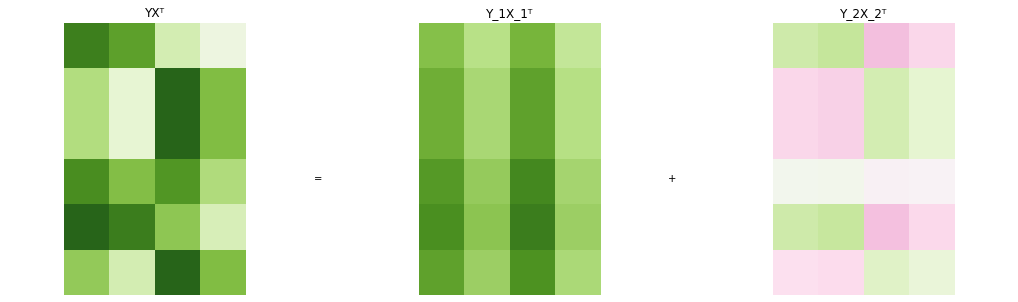

In [392]:
plt.figure(2, figsize=(18, 5))
#--------------
plt.subplot(1,3,1)
plt.imshow(Y@X.T,vmin = -5, vmax = 5)
plt.title("YXᵀ")
plt.axis('equal')
plt.axis('off')
plt.text(5,3, '=')

plt.subplot(1,3,2)
plt.imshow(np.outer(Y[:,0],X[:,0]),vmin = -5, vmax = 5)
plt.title("Y_1X_1ᵀ")
plt.axis('equal')
plt.axis('off')
plt.text(5,3, '+')

plt.subplot(1,3,3)
plt.imshow(np.outer(Y[:,1],X[:,1]),vmin = -5, vmax = 5)
plt.title("Y_2X_2ᵀ")
plt.axis('equal')
plt.axis('off')
plt.show()

## What Happens When We Increase the Rank?

In [405]:
X = Vᵀ.T[:,0:3]*np.sqrt(s[0:3])
Y = U[:,0:3]*np.sqrt(s[0:3])

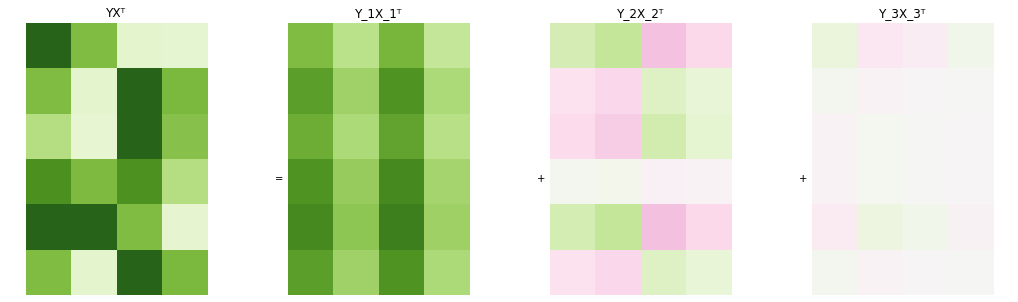

In [406]:
plt.figure(2, figsize=(18, 5))
#--------------
plt.subplot(1,4,1)
plt.imshow(Y@X.T,vmin = -5, vmax = 5)
plt.title("YXᵀ")
plt.set_cmap('PiYG')
plt.axis('equal')
plt.axis('off')
plt.text(5,3, '=')

plt.subplot(1,4,2)
plt.imshow(np.outer(Y[:,0],X[:,0]),vmin = -5, vmax = 5)
plt.title("Y_1X_1ᵀ")
plt.axis('equal')
plt.axis('off')
plt.text(5,3, '+')

plt.subplot(1,4,3)
plt.imshow(np.outer(Y[:,1],X[:,1]),vmin = -5, vmax = 5)
plt.title("Y_2X_2ᵀ")
plt.axis('equal')
plt.axis('off')
plt.text(5,3, '+')

plt.subplot(1,4,4)
plt.imshow(np.outer(Y[:,2],X[:,2]),vmin = -5, vmax = 5)
plt.title("Y_3X_3ᵀ")
plt.axis('equal')
plt.axis('off')
plt.show()

The approximating data matrix, visualized by the matrix on the left above, is given as:

In [407]:
Y@X.T

array([[5.02, 2.97, 1.03, 0.94],
       [2.98, 1.03, 4.97, 3.07],
       [2.05, 0.93, 5.08, 2.84],
       [3.99, 3.02, 3.98, 2.04],
       [5.  , 5.01, 2.99, 1.01],
       [2.98, 1.03, 4.97, 3.07]])

## Towards a More Advanced Recommender System
How can we prevent the approximation to the inserted mean values?

Adapt the objective to approximate only observed entries.
The following approach has been used in the Netflix Price 2009 competition and made it to the top-3:
`````{admonition} Task (Rank-r Matrix Factorization with Missing Values)
:class: tip
**Given** a data matrix $D\in\mathbb{R}^{n\times d}$ having observed entries $D_{ik}$ for $(i,k)\in\mathcal{O}\subseteq \{1,\ldots,n\}\times \{1,\ldots d\}$ the set of observed matrix entries, and a rank $r<\min\{n,d\}$.     
    
**Find** matrices $X\in\mathbb{R}^{d\times r}$ and $Y\in\mathbb{R}^{n\times r}$ whose product approximates the data matrix only on observed entries, indicated by $\mathbb{1}_{\mathcal{O}}$:
\begin{align}
    \min_{X,Y}&\lVert \mathbb{1}_{\mathcal{O}}\circ(D- YX^\top)\rVert^2 =\sum_{(i,k)\in\mathcal{O}}(D_{ik}-Y_{i\cdot}X_{k\cdot}^\top)^2\\ 
    \text{s.t. }& X\in \mathbb{R}^{d\times r}, Y\in\mathbb{R}^{n\times r}
\end{align}
**Return** the low-dimensional approximation of the data $(X,Y)$.  
`````
We can optimze this objective with coordinate descent. We will not go through this approach in detail, but you can try to implement this for yourself.